In [896]:
import csv
import random
import math
import operator

import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix

In [897]:
stock = 'aapl'

df = pd.read_csv('%s.us.txt' % stock, index_col=0)
df.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
print(df.shape)
df.head()

(8364, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062


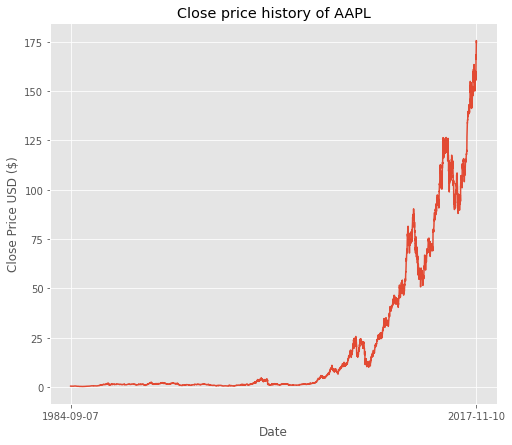

In [898]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

## 1. Exploring Rolling Mean and Return Rate of Stocks
In this analysis, we analyse stocks using two key measurements: Rolling Mean and Return Rate.

### Rolling Mean (Moving Average) — to determine trend

Rolling mean/Moving Average (MA) smooths out price data by creating a constantly updated average price. This is useful to cut down “noise” in our price chart. Furthermore, this Moving Average could act as “Resistance” meaning from the downtrend and uptrend of stocks you could expect it will follow the trend and less likely to deviate outside its resistance point.

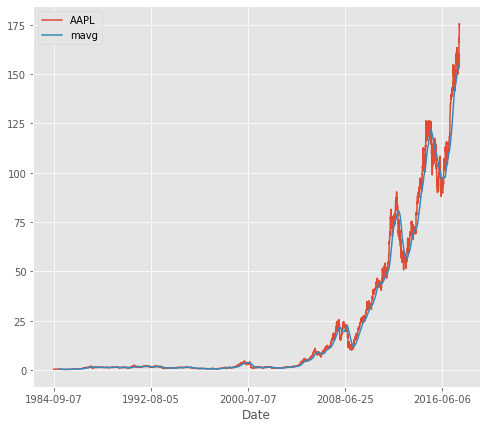

In [899]:
# Calculate the Moving Average for the last 100 windows (100 days) of stocks closing price and take the average for each of the window’s moving average.
close_px = df['Close']
mavg = close_px.rolling(window=100).mean()

# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

The Moving Average makes the line smooth and showcase the increasing or decreasing trend of stocks price.
In this chart, the Moving Average showcases increasing trend the upturn or downturn of stocks price. Logically, you should buy when the stocks are experiencing downturn and sell when the stocks are experiencing upturn.

### Return Deviation — to determine risk and return

Expected Return measures the mean, or expected value, of the probability distribution of investment returns. The expected return of a portfolio is calculated by multiplying the weight of each asset by its expected return and adding the values for each investment.

<AxesSubplot:xlabel='Date'>

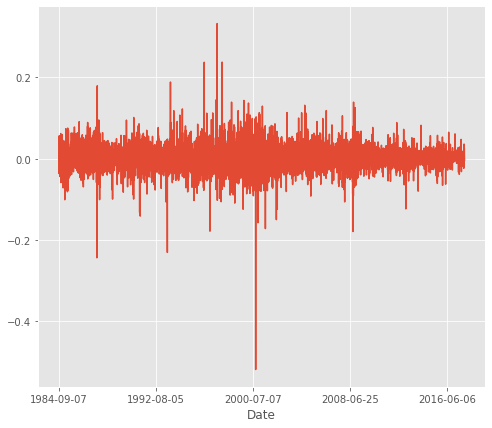

In [900]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

Logically, our ideal stocks should return as high and stable as possible.

## 2. Predicting Stocks Price.

### Feature Engineering

We will use K Nearest Neighbor (KNN) to predict our stocks. 

We will first engineer 2 new features: High Low Percentage and Percentage Change.

In [901]:
dfreg = df.loc[:,['Close','Volume']]
dfreg['HL_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['Percent_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.head(10)

,Close,Volume,HL_Percent,Percent_Change
Date,,,,
1984-09-07,0.42388,23220030,2.425215,0.000000
1984-09-10,0.42134,18022532,2.729387,-0.599226
1984-09-11,0.42902,42498199,2.685190,0.907893
1984-09-12,0.41618,37125801,3.697919,-2.992867
1984-09-13,0.43927,57822062,0.284563,0.000000
1984-09-14,0.44566,68847968,3.448817,1.166803
1984-09-17,0.45718,53755262,1.397699,0.000000
1984-09-18,0.44052,27136886,4.655861,-3.644079
1984-09-19,0.43157,29641922,3.264824,-2.031690


### Pre-processing & Data split

We will clean up and process the data using the following steps before putting them into the prediction models:
1. Drop missing value
2. Separating the label here, we want to predict the Close
3. Scale the X so that everyone can have the same distribution
4. Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Separation of training and testing of model by train test split

In [902]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the future Close
forecast_col = 'Close'
dfreg['Label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['Label'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
#X = preprocessing.scale(X)

# Find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['Label'])
y = y[:-forecast_out]

# Separation of training and testing of model by train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### K Nearest Neighbour (KNN) - Evaluation (Regression)

In [903]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=7, metric="euclidean")
clfknn.fit(X_train, y_train)

#print('kNN accuracy for training set: %f' % clfknn.score(X_train, y_train))
#print('kNN accuracy for test set: %f' % clfknn.score(X_test, y_test))
print('kNN RMSE for training set: %f' % math.sqrt(mean_squared_error(y_train,clfknn.predict(X_train))))
print('kNN RMSE for test set: %f' % math.sqrt(mean_squared_error(y_test,clfknn.predict(X_test))))

kNN RMSE for training set: 4.806626
kNN RMSE for test set: 6.282809


Above shows an RMSE of around 6.28 on the test set, which is slightly larger than the train set RMSE of 4.81. Below is a gragh to help us visualise the data better.

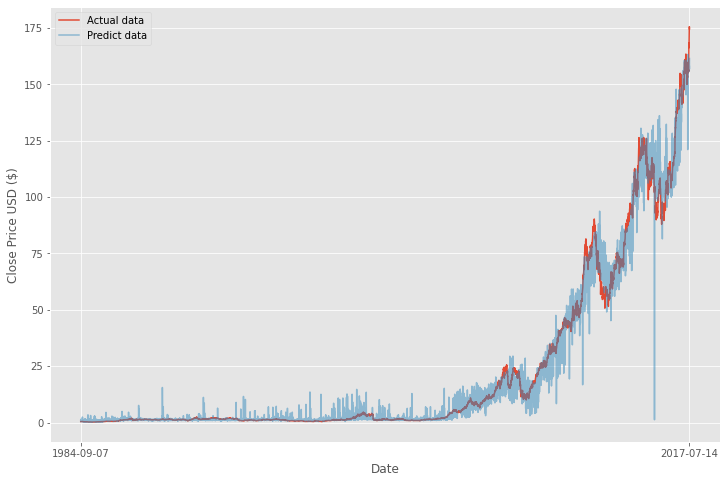

In [904]:
y_val = dfreg[:-forecast_out]
y_val_pred = clfknn.predict(X)
val1 = dfreg[:-forecast_out].copy()
val1['Label'] = np.ravel(y_val_pred)

plt.figure(figsize=(12,8))
plt.plot(y_val['Label'], label='Actual data')
plt.plot(val1['Label'], label='Predict data', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(y_val.index.values)[0], list(y_val.index.values)[-1]])
plt.legend()
plt.show()


In [905]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_val['Label'])-np.array(y_val_pred)),2)))
print("RMSE of above gragh: " + str(rms))

RMSE of above gragh: 5.135918848239008


We can see that the variation on the model's predicted values is quite large, making it hard to predict very accurate values. However, using our model, we can roughly forecast and predict future stocks pricing. We will visualize the plot with our existing historical data.

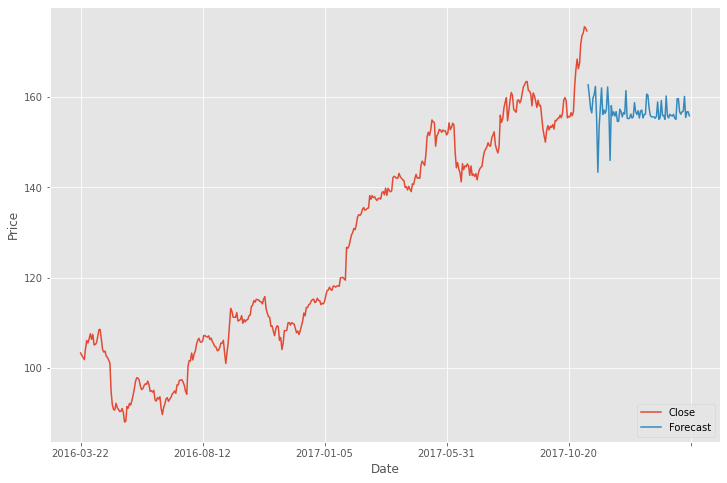

In [906]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = datetime.datetime.strptime(last_date, "%Y-%m-%d")
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

plt.figure(figsize=(12,8))
dfreg['Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see the blue color showcased the forecast on the stocks price. The forecast predicted that there would be a downturn.

### Another approach by adding additional feature Month_Percent_Change

In [907]:
dfreg2 = df.loc[:,['Close','Volume']]
dfreg2['HL_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg2['Percent_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg2['Month_Percent_Change'] = (df['Close'].shift(30) - df['Open']) / df['Open'] * 100.0

# Drop missing value
dfreg2.dropna(subset= ['Month_Percent_Change'], inplace=True)

dfreg2.head()

,Close,Volume,HL_Percent,Percent_Change,Month_Percent_Change
Date,,,,,
1984-10-19,0.40853,90949795,7.206325,0.000000,3.757374
1984-10-22,0.40593,32003288,2.212204,-0.636428,3.135633
1984-10-23,0.41491,51993625,0.923092,0.000000,3.400738
1984-10-24,0.41874,46577491,1.227492,0.000000,-0.611358
1984-10-25,0.40339,44109940,3.805251,-3.665759,4.902804


In [908]:
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg2)))

# Separating the label here, we want to predict the future Close
forecast_col = 'Close'
dfreg2['Label'] = dfreg2[forecast_col].shift(-forecast_out)
X = np.array(dfreg2.drop(['Label'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
#X = preprocessing.scale(X)

# Find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg2['Label'])
y = y[:-forecast_out]

# Separation of training and testing of model by train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# KNN Regression
clfknn2 = KNeighborsRegressor(n_neighbors=7, metric="euclidean")
clfknn2.fit(X_train, y_train)

print('kNN RMSE for training set: %f' % math.sqrt(mean_squared_error(y_train,clfknn2.predict(X_train))))
print('kNN RMSE for test set: %f' % math.sqrt(mean_squared_error(y_test,clfknn2.predict(X_test))))

kNN RMSE for training set: 4.848997
kNN RMSE for test set: 5.355844


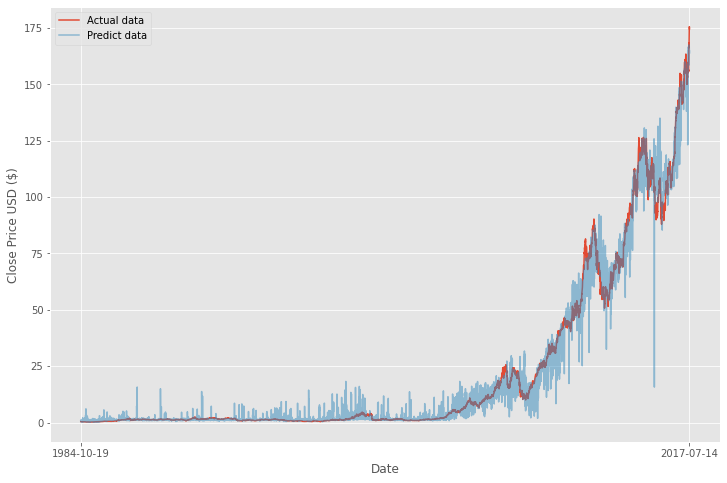

In [909]:
y_val = dfreg2[:-forecast_out]
y_val_pred = clfknn2.predict(X)
val1 = dfreg2[:-forecast_out].copy()
val1['Label'] = np.ravel(y_val_pred)

plt.figure(figsize=(12,8))
plt.plot(y_val['Label'], label='Actual data')
plt.plot(val1['Label'], label='Predict data', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(y_val.index.values)[0], list(y_val.index.values)[-1]])
plt.legend()
plt.show()

### K Nearest Neighbour (KNN) - Evaluation (Classification)

Let's take a look at our processed data again. For this classification problem, we will set the label as either 'Up' or 'Down' depending on the next day's close price compared to today's.

In [910]:
dfclass = df.loc[:,['Close','Volume']]
dfclass['HL_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfclass['Percent_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfclass['Label'] = np.where(dfclass['Close']>dfclass['Close'].shift(-1), "Down", "Up")

dfclass.head(10)

,Close,Volume,HL_Percent,Percent_Change,Label
Date,,,,,
1984-09-07,0.42388,23220030,2.425215,0.000000,Down
1984-09-10,0.42134,18022532,2.729387,-0.599226,Up
1984-09-11,0.42902,42498199,2.685190,0.907893,Down
1984-09-12,0.41618,37125801,3.697919,-2.992867,Up
1984-09-13,0.43927,57822062,0.284563,0.000000,Up
1984-09-14,0.44566,68847968,3.448817,1.166803,Up
1984-09-17,0.45718,53755262,1.397699,0.000000,Down
1984-09-18,0.44052,27136886,4.655861,-3.644079,Down
1984-09-19,0.43157,29641922,3.264824,-2.031690,Up


In [911]:
X = np.array(dfclass.drop(['Label'], axis=1))
X = scaler.fit_transform(X)

y = np.array(dfclass['Label'])

# Separation of training and testing of model by train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# KNN Classification
clfknn = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
clfknn.fit(X_train, y_train)

print('kNN accuracy for training set: %f' % clfknn.score(X_train, y_train))
print('kNN accuracy for test set: %f' % clfknn.score(X_test, y_test))

kNN accuracy for training set: 0.658496
kNN accuracy for test set: 0.518231


Above shows an accuracy score (about 0.52) for our KNN model, which is slightly more that 50%. Hence we see that it is harder to predict using KNN with classification.

## 3.  Comparing Apple's stock with competitors' stocks

This segment will analyse on how our model's company (Apple) performs in relative with its competitors, and whether we can use the same model to predict those stocks.

In [912]:
stock_apple = 'aapl'
stock_ge = 'ge'
stock_google = 'goog'
stock_ibm = 'ibm'
stock_microsoft = 'msft'

df_aapl = pd.read_csv('%s.us.txt' % stock_apple, index_col=0)
df_aapl.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
df_aapl.rename(columns = {'Close':'AAPL'}, inplace = True)

df_ge = pd.read_csv('%s.us.txt' % stock_ge, index_col=0)
df_ge.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
df_ge.rename(columns = {'Close':'GE'}, inplace = True)

df_goog = pd.read_csv('%s.us.txt' % stock_google, index_col=0)
df_goog.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
df_goog.rename(columns = {'Close':'GOOG'}, inplace = True)

df_ibm = pd.read_csv('%s.us.txt' % stock_ibm, index_col=0)
df_ibm.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
df_ibm.rename(columns = {'Close':'IBM'}, inplace = True)

df_msft = pd.read_csv('%s.us.txt' % stock_microsoft, index_col=0)
df_msft.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
df_msft.rename(columns = {'Close':'MSFT'}, inplace = True)


df_temp1 = pd.merge(df_aapl['AAPL'], df_ge['GE'], how='inner', on='Date')
df_temp2 = pd.merge(df_temp1, df_goog['GOOG'], how='inner', on='Date')
df_temp3 = pd.merge(df_temp2, df_ibm['IBM'], how='inner', on='Date')
df_comp = pd.merge(df_temp3, df_msft['MSFT'], how='inner', on='Date')

df_comp.head(10)

,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2014-03-27,71.611,22.960,558.46,167.34,35.954
2014-03-28,71.531,23.020,559.99,167.90,36.814
2014-03-31,71.513,23.030,556.97,169.68,37.441
2014-04-01,72.168,23.011,567.16,171.45,37.834
2014-04-02,72.290,23.165,567.00,170.62,37.769
2014-04-03,71.787,23.331,569.74,169.87,37.459
2014-04-04,70.858,23.145,543.14,169.06,36.419
2014-04-07,69.746,22.993,538.15,171.47,36.355
2014-04-08,69.741,22.904,554.90,170.38,36.374


### Correlation Analysis

We run a percentage change and correlation function in pandas to analyse the various stocks. Percentage change can see how much price changes compared to the previous day which will give us the returns. Getting the correlation can help us see if the returns are affected by the other stocks' returns.

In [913]:
return_comp = df_comp.pct_change()
corr = return_comp.corr()
corr.head()

,AAPL,GE,GOOG,IBM,MSFT
AAPL,1.000000,0.301626,0.399243,0.301416,0.469998
GE,0.301626,1.000000,0.314059,0.434169,0.380935
GOOG,0.399243,0.314059,1.000000,0.336044,0.572938
IBM,0.301416,0.434169,0.336044,1.000000,0.419150
MSFT,0.469998,0.380935,0.572938,0.419150,1.000000


Below is a plot showing the return distributions between Apple and Microsoft.

Text(0, 0.5, 'Returns MSFT')

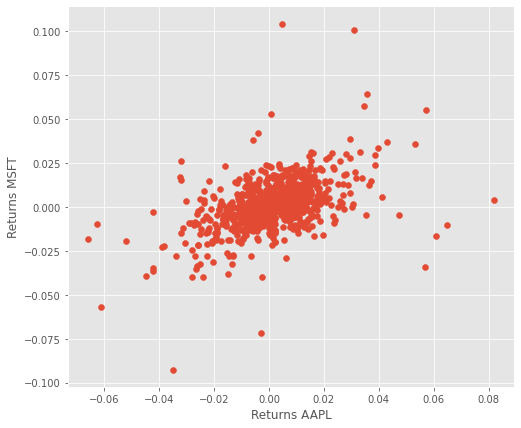

In [914]:
plt.scatter(return_comp.AAPL, return_comp.MSFT)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns MSFT')

There is a slight positive correlation among the returns of Apple and Microsoft. Meaning that the higher the returns for Apple, the higher the returns for Microsoft generally.

Below we will plot a similar gragh showing the relation between each and every company. For the diagonal plot, a Kernal Density Estimate (KDE) is used to help generate estimations of the overall distribution.

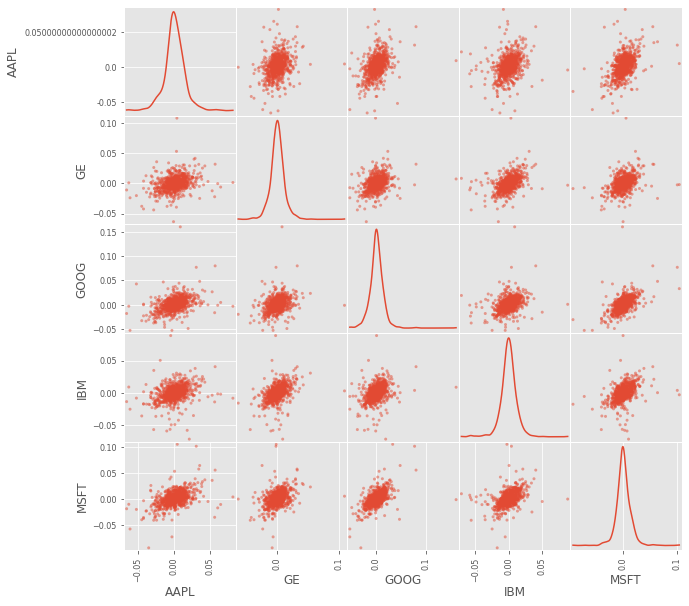

In [915]:
scatter_matrix(return_comp, diagonal='kde', figsize=(10, 10));

From the scatter matrix above, we can see that there is slight positive correlations among the various stocks. We can better visualise the positive correlations using a heat map.

([<matplotlib.axis.YTick at 0x134125e50>,
 [Text(0, 0, 'AAPL'),
  Text(0, 1, 'GE'),
  Text(0, 2, 'GOOG'),
  Text(0, 3, 'IBM'),
  Text(0, 4, 'MSFT')])

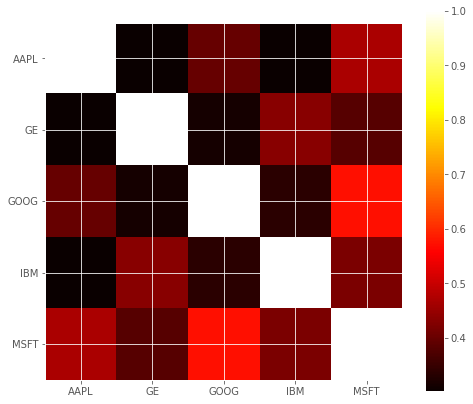

In [916]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

Note that the lighter the colour, the more correlated the 2 stocks are.

From the heat map and the scatter matrix, we can tell that there are correlations between the competitive technological companies. We need to note that this does not show causality, as it might be due to the trend for the tech industry over the years. However it is also possible that the companies' stocks can affect one another.